In [1]:
import pandas as pd
import os
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import random
import importlib
from scipy.stats import randint, expon, uniform

import sklearn as sk
from sklearn import svm
from sklearn.utils import shuffle
from sklearn import metrics
from sklearn import preprocessing
from sklearn import pipeline
from sklearn.model_selection import cross_val_score, StratifiedKFold, RandomizedSearchCV

from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.neural_network import MLPRegressor
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.gaussian_process.kernels import RBF

from LoadData import load_data
import PlottingHelpers
import ProcessingHelpers

importlib.reload(ProcessingHelpers) # while still working on than fun
importlib.reload(PlottingHelpers) # while still working on than fun

<module 'PlottingHelpers' from '/home/jovyan/python-ml-turbofan/PlottingHelpers.py'>

In [2]:
sns.set() 

In [3]:
dirname = os.getcwd()
pth = os.path.join(dirname, 'CMAPSSData')

print('loading data...')
dc = load_data(pth)
print('done')

loading data...
done


In [4]:
# get the first data set training data
df = dc['FD_001']['df_train'].copy()

# Make a Column for the RUL target data (y)

According to the data description document the data set contains multiple units, each unit starts at a certain degradation point and the measurement data ends closely before the unit was decommissioned of broke. 

Therefore assume, that for the last measurement time that is available for a unit the units RUL=0 (stopped measuring just before machine broke)


In [5]:
# get the time of the last available measurement for each unit
mapper = {}
for unit_nr in df['unit_nr'].unique():
    mapper[unit_nr] = df['time'].loc[df['unit_nr'] == unit_nr].max()
    
# calculate RUL = time.max() - time_now for each unit
df['RUL'] = df['unit_nr'].apply(lambda nr: mapper[nr]) - df['time']

## Drop the nan columns and rows

In [6]:
cols_nan = df.columns[df.isna().any()].tolist()
print('Columns with all nan: \n' + str(cols_nan) + '\n')

cols_const = [ col for col in df.columns if len(df[col].unique()) <= 2 ]
print('Columns with all const values: \n' + str(cols_const) + '\n')

Columns with all nan: 
['sensor_22', 'sensor_23', 'sensor_24', 'sensor_25', 'sensor_26']

Columns with all const values: 
['os_3', 'sensor_01', 'sensor_05', 'sensor_06', 'sensor_10', 'sensor_16', 'sensor_18', 'sensor_19', 'sensor_22', 'sensor_23', 'sensor_24', 'sensor_25', 'sensor_26']



In [7]:
df = df.drop(columns=cols_const + cols_nan)

## Normalize the dataset as shown in the Explorative_analysis notebook

In [8]:
df_start = df.loc[df['time'] < 10.0].copy()
cols_non_data = [col for col in df.columns if not col.startswith('sens')]
bias = df_start.mean()
scale = df_start.var()

bias[cols_non_data] = 0.0
scale[cols_non_data] = 1.0

df_n = (df - bias) / scale
#df_n = df.copy()

take out a certain percentage of units from the training data set for testing later, (additionally to the classic validation methods)


In [9]:
units = df_n['unit_nr'].unique()
n_units = len(df_n['unit_nr'].unique())

units_test = random.sample(list(units), int(n_units * 0.2))
units_train = [nr for nr in units if nr not in units_test]

df_n_test = df_n.loc[df_n['unit_nr'].apply( lambda x: x in units_test )].copy()
df_n_train = df_n.loc[df_n['unit_nr'].apply( lambda x: x in units_train )].copy()

Get the training data and shuffle if to break the time dependency

In [10]:
df_n_train.describe()

,unit_nr,time,os_1,os_2,sensor_02,sensor_03,sensor_04,sensor_07,sensor_08,sensor_09,sensor_11,sensor_12,sensor_13,sensor_14,sensor_15,sensor_17,sensor_20,sensor_21,RUL
count,16443.000000,16443.000000,16443.000000,16443.000000,16443.000000,16443.000000,16443.000000,16443.000000,16443.000000,16443.000000,16443.000000,16443.000000,16443.000000,16443.000000,16443.000000,16443.000000,16443.000000,16443.000000,16443.000000
mean,51.499118,109.014596,-0.000009,0.000002,2.127537,0.170697,0.177625,-1.452639,12.653883,0.121841,6.022351,-1.897012,13.137265,0.093681,32.953547,0.700724,-6.798568,-10.806555,108.014596
std,30.852915,69.752655,0.002177,0.000293,3.555586,0.285330,0.259594,2.198930,23.442684,0.309987,8.571260,2.761171,23.457748,0.301104,52.889564,1.165401,10.471881,16.671086,69.752655
min,1.000000,1.000000,-0.008700,-0.000600,-7.859744,-0.735588,-0.588925,-10.253492,-52.250101,-0.480940,-16.070463,-12.185381,-57.379848,-0.589246,-132.009789,-3.206230,-46.306977,-72.250329,0.000000
25%,24.000000,52.000000,-0.001500,-0.000300,-0.397437,-0.026001,-0.010663,-2.824770,-2.638597,-0.051560,0.008933,-3.607424,-5.107449,-0.073103,-5.333023,-0.192541,-13.156250,-21.208099,51.000000
50%,53.000000,103.000000,0.000000,0.000000,1.805720,0.149414,0.148699,-1.229340,10.591137,0.062070,5.154340,-1.613425,11.227676,0.047754,27.891352,0.560881,-5.595558,-9.471942,102.000000
75%,80.000000,156.000000,0.001500,0.000300,4.364226,0.348621,0.337796,0.141733,27.128306,0.183075,10.942922,0.117215,27.562801,0.166797,66.064039,1.314303,0.801950,1.019470,155.000000
max,100.000000,362.000000,0.008700,0.000600,15.308942,1.404371,1.121322,4.379594,152.810783,2.581461,37.956307,5.459627,164.777849,2.411435,235.437661,5.834836,28.718351,39.730231,361.000000


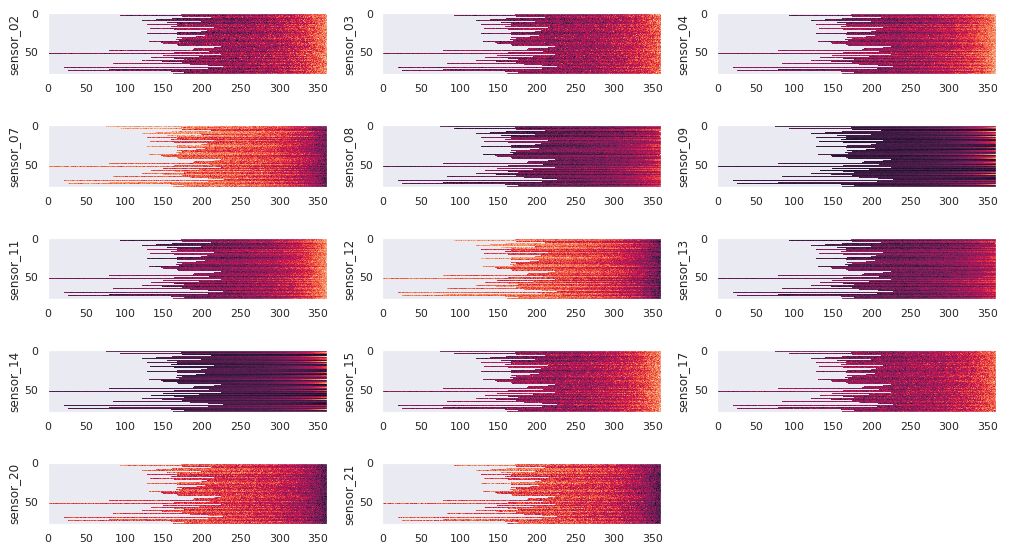

In [11]:
cols_features = [c for c in df_n_train.columns if c.startswith('o') or c.startswith('s')]

PlottingHelpers.plot_imshow(df_n_train, resample=False)


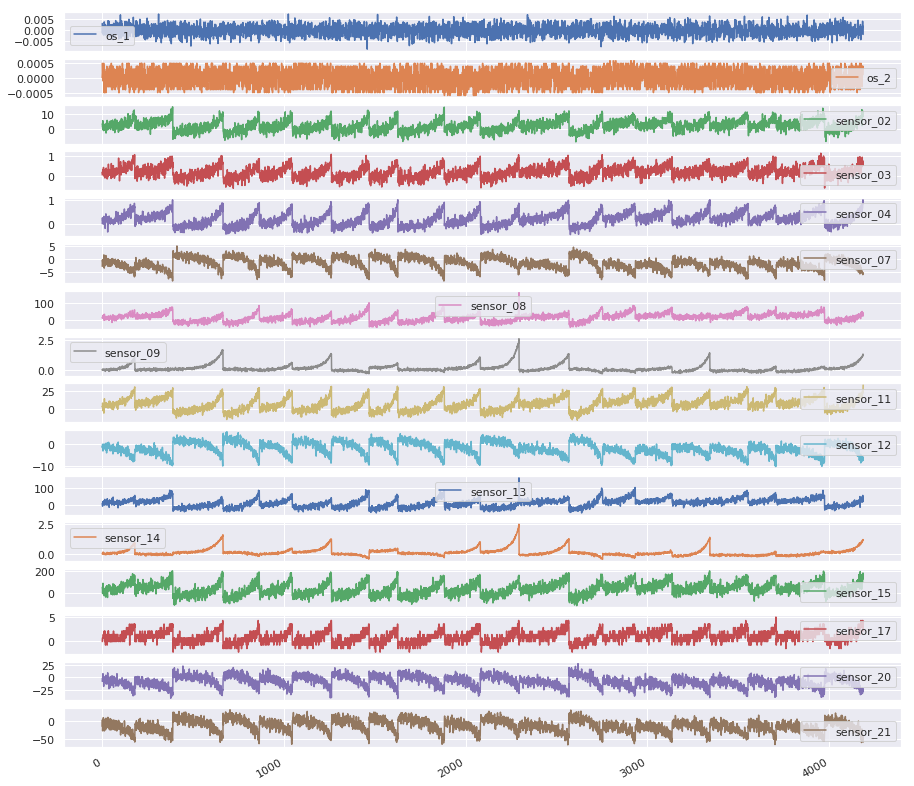

In [12]:
t = pd.DataFrame(df_n_test[cols_features].values, columns=cols_features).plot(subplots=True, figsize=(15, 15))

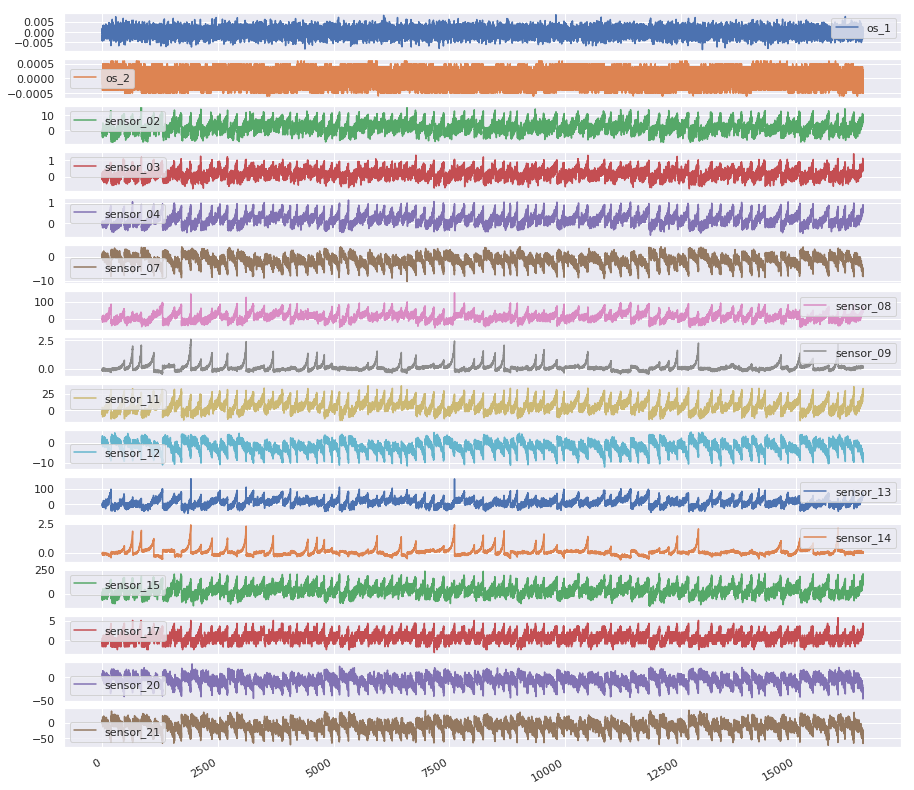

In [13]:
t = pd.DataFrame(df_n_train[cols_features].values, columns=cols_features).plot(subplots=True, figsize=(15, 15))

## Do a simple support vector machine based regression based on all training data

define a helper function for the simple fitting through a support vector machine

In [14]:
def fit_and_test_clf(df_n_train, df_n_test, mdl=None, cols_features=None):
    
    if cols_features is None:
        cols_features = [c for c in df_n_train.columns if c.startswith('s')]

    X_train = df_n_train[cols_features].values
    y_train = df_n_train['RUL'].values

    X_test = df_n_test[cols_features].values
    y_test = df_n_test['RUL'].values

    print(X_train.shape)
    if mdl is None:
        mdl = sk.pipeline.Pipeline([
            ('scaler', sk.preprocessing.MinMaxScaler()),
            ('regression', sk.svm.SVR(gamma='scale')),
        ])

    scoring = sk.metrics.mean_squared_error

    y_cv = sk.model_selection.cross_val_predict(
        mdl,
        X_train,
        y_train,
        cv=3,
    )

    mdl.fit(X_train, y_train)
    y_test_p = mdl.predict(X_test)


    scoring = sk.metrics.mean_squared_error

    print("cv test mse: %s" % scoring(y_cv, y_train))
    print("testing units mse: %s" % scoring(y_test_p, y_test))

    res_full = {
        'dy_train_cv': y_cv - y_train,
        'dy_test': y_test_p - y_test,
        'y_train_p_cv': y_cv,
        'y_test_p': y_test_p,
    }

    # Exclude the channels 14 and 9 since they are not generally falling or raising, 
    # and the channels 8,11,12,13,14 since they are highly correlating

    exclude = [ 'sensor_{}'.format(n) for n in ['08', '09', '11', '12', '13', '14'] ]
    cols_features2 = [c for c in cols_features if c.startswith('s') and c not in exclude]

    X_train = df_n_train[cols_features2].values
    y_train = df_n_train['RUL'].values

    X_test = df_n_test[cols_features2].values
    y_test = df_n_test['RUL'].values

    print(X_train.shape)

    mdl = sk.pipeline.Pipeline([
        ('scaler', sk.preprocessing.MinMaxScaler()),
        ('regression', sk.svm.SVR(gamma='scale')),
    ])

    scoring = sk.metrics.mean_squared_error

    y_cv = sk.model_selection.cross_val_predict(
        mdl,
        X_train,
        y_train,
        cv=3,
    )

    mdl.fit(X_train, y_train)
    y_test_p = mdl.predict(X_test)

    scoring = sk.metrics.mean_squared_error

    print("cv test mse: %s" % scoring(y_cv, y_train))
    print("testing units mse: %s" % scoring(y_test_p, y_test))

    res_red = {
        'dy_train_cv': y_cv - y_train,
        'dy_test': y_test_p - y_test,
        'y_train_p_cv': y_cv,
        'y_test_p': y_test_p,
    }
    return res_full, res_red


In [15]:
res = {}

In [16]:
res_full, res_red = fit_and_test_clf(df_n_train, df_n_test, mdl=None, cols_features=None)
    
res['all_full'] = res_full
res['all_red'] = res_red

(16443, 14)
cv test mse: 2014.9797882398448
testing units mse: 2011.2628827886483
(16443, 8)
cv test mse: 2204.2754815496296
testing units mse: 2302.3026922942004


/opt/conda/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


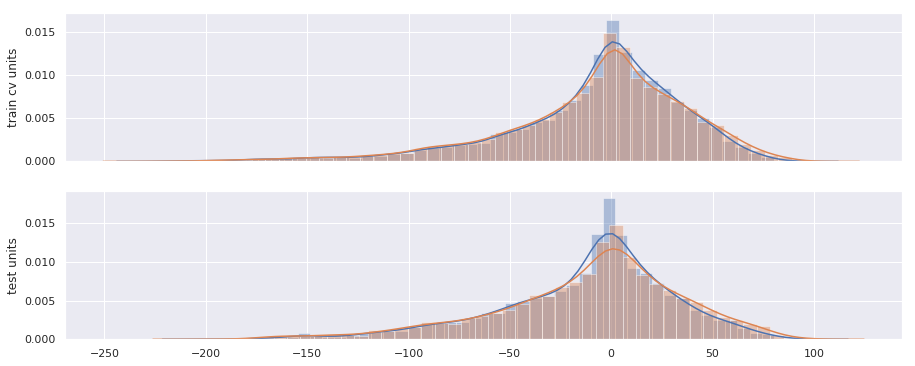

In [19]:
fig, axes = plt.subplots(2, 1, figsize=(15, 6), sharex=True)
axes = axes.flatten()

for name, dc2 in res.items():
    sns.distplot(dc2['dy_train_cv'], ax=axes[0])
    sns.distplot(dc2['dy_test'], ax=axes[1])
    
lbl = axes[1].set_ylabel('test units')
lbl = axes[0].set_ylabel('train cv units')

the model(s) seems to converge, but the error distributions do not look very good, considering the fact, that some predictions are nearly 100 cycles off, while some units just have a life cylcle of about 125 cycles.

Lets take a look, how the regression values progress over the life cycle of each unit.

## Plot the progression of the predicted RULs over time:

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until


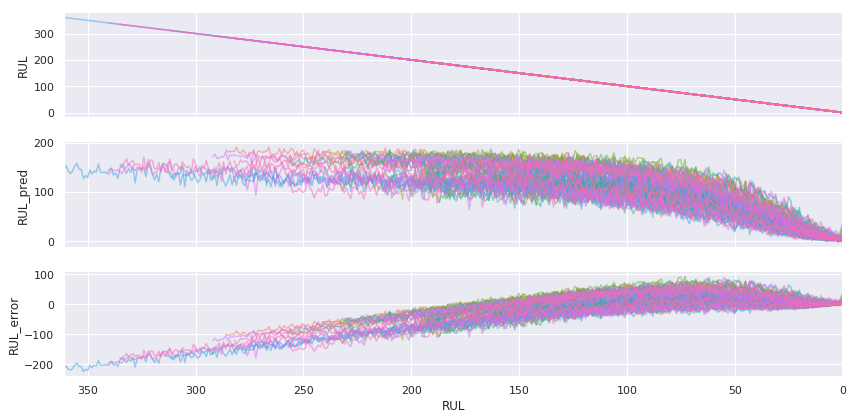

In [21]:
tmp = df_n_train[['RUL', 'unit_nr']]
tmp['RUL_error'] = res['all_full']['dy_train_cv']
tmp['RUL_pred'] = res['all_full']['y_train_p_cv']

PlottingHelpers.plot_grouped_by_RUL(tmp, leg=False, cols_data=['RUL', 'RUL_pred', 'RUL_error'])

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until


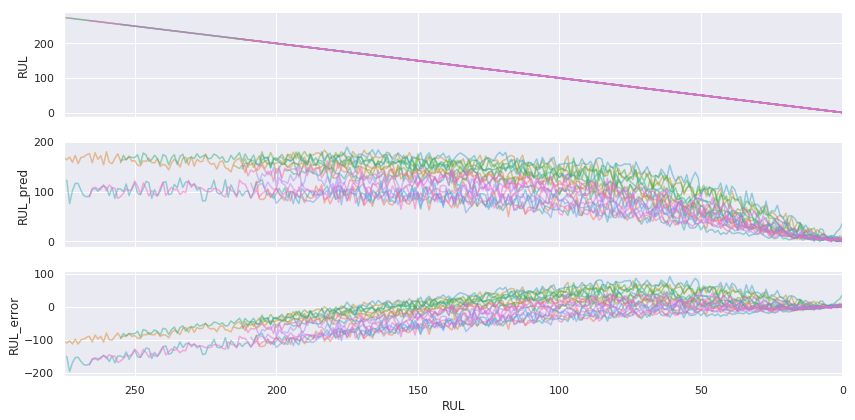

In [25]:
tmp = df_n_test[['RUL', 'unit_nr']]
tmp['RUL_error'] = res['all_full']['dy_test']
tmp['RUL_pred'] = res['all_full']['y_test_p']

PlottingHelpers.plot_grouped_by_RUL(tmp, leg=False, cols_data=['RUL', 'RUL_pred', 'RUL_error'])

The predicted RULs are especially off at the beginning of the life cycle of a unit, but seem to get closer the more a machine nears to the end of it's life. This is especially valuable, when it comes to protecting the unit from damage, or scheduling maintenance closely to a breakdown.

One way to achieve that, would be to directly model the whole problem as a binary classification problem, another would be to simply thresthold the predicted RUL's by a thresthold value for the RUL. In order to robustify the model further against noise it can make sens to debounce the actual threstholding using a floating median filter.

## Do a quick inspection of a binary threstholding for the test data set results:

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


(275.0, 0.0)

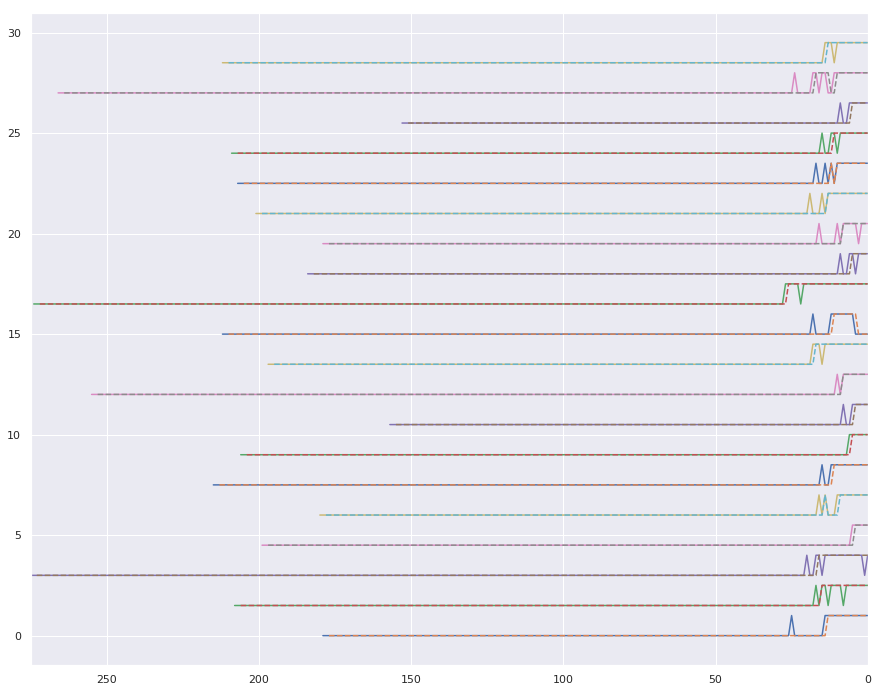

In [95]:
tmp = df_n_test[['RUL', 'unit_nr', 'time']]
tmp['FAILURE_NEAR'] = res['all_full']['y_test_p'] < 10.0

fig, ax = plt.subplots(1, 1, figsize=(15,12))

for i, (name, tmp2) in enumerate(tmp.groupby('unit_nr')):
    y = tmp2['FAILURE_NEAR'] + (i * 1.5)
    y_med = tmp2['FAILURE_NEAR'].rolling(3).median() + (i * 1.5)
     
    ax.plot(tmp2['RUL'].values, y)
    ax.plot(tmp2['RUL'].values, y_med, linestyle='--')
   
ax.set_xlim((df_n_test['RUL'].max(),df_n_test['RUL'].min()))

That looks promising. So lets investigate a bit further.


## define a mapping function to make the regressed values binary classifications:

In [96]:
def map_2_n_looks_ahead(df_loc, res_now, n_ahead = 10):
    tmp = df_loc[['RUL', 'unit_nr', 'time']]
    tmp['FAILURE_NEAR'] = res_now < n_ahead
    df_predictions = {
        'unit_nr': [],
        'FailureFoundAtEnd': [],
        'FailurePredictionError': [],
        'FailureFoundAtEndMedian': [],
        'FailurePredictionErrorMedian': []
    }

    for i, (name, tmp2) in enumerate(tmp.groupby('unit_nr')):
        wind_size = 3
        y = tmp2['FAILURE_NEAR'] * 1.0
        y_med = tmp2['FAILURE_NEAR'].rolling(wind_size).median()

        RUL_first = n_ahead - tmp2[y > 0].iloc[0]['RUL']
        RUL_first_med = n_ahead - np.ceil(wind_size/2) - tmp2[y_med > 0].iloc[0]['RUL']

        df_predictions['unit_nr'].append(name)
        df_predictions['FailureFoundAtEnd'].append(y.iloc[-1])
        df_predictions['FailurePredictionError'].append(RUL_first)
        df_predictions['FailureFoundAtEndMedian'].append(y_med.iloc[-1])
        df_predictions['FailurePredictionErrorMedian'].append(RUL_first_med)


    df_predictions = pd.DataFrame(df_predictions)
    df_predictions = df_predictions.set_index('unit_nr')
    return df_predictions

## Analyze if unit breakdowns are predicted properly for the cross validated data set

units with failure not found at end:
[51.0]
units with failure not found at end (with median):
[51.0]

total number of units where failures are not found properly:
with median   : 1/20 (5.0%)
without median: 1/20 (5.0%)


/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/opt/conda/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


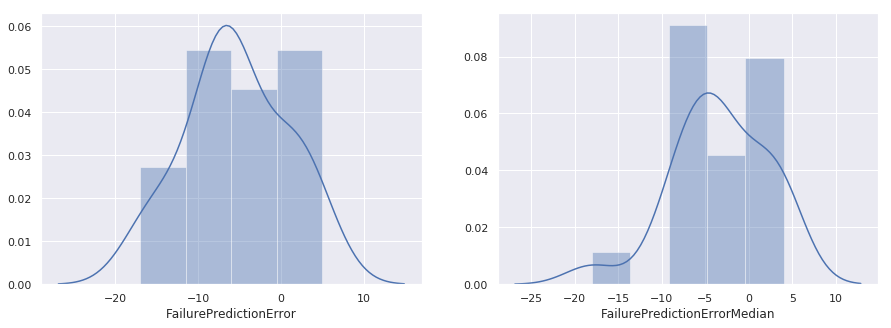

In [92]:
#a = df_predictions.plot.bar(figsize=(15,12), subplots=True)
df_predictions = map_2_n_looks_ahead(df_n_test, res['all_full']['y_test_p'])

yy = list(df_predictions[df_predictions['FailureFoundAtEnd'] == 0].index)
yy_med = list(df_predictions[df_predictions['FailureFoundAtEndMedian'] == 0].index)

print('units with failure not found at end:\n{}'.format(yy))
print('units with failure not found at end (with median):\n{}'.format(yy_med))
print('\ntotal number of units where failures are not found properly:')
print('with median   : {}/{} ({}%)'.format(len(yy_med), len(df_predictions), len(yy_med) / len(df_predictions) * 100))
print('without median: {}/{} ({}%)'.format(len(yy), len(df_predictions), len(yy) / len(df_predictions) * 100))

fig, axes = plt.subplots(1, 2, figsize=(15,5))
axes = axes.flatten()
sns.distplot(df_predictions['FailurePredictionError'], ax=axes[0])
sns.distplot(df_predictions['FailurePredictionErrorMedian'], ax=axes[1])

## Analyze if unit breakdowns are predicted properly for the testing data set

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until


units with failure not found at end:
[3.0, 4.0, 9.0, 18.0, 48.0, 55.0, 82.0, 97.0]
units with failure not found at end (with median):
[3.0, 9.0, 18.0, 48.0, 82.0, 97.0]

total number of units where failures are not found properly:
with median   : 6/80 (7.5%)
without median: 8/80 (10.0%)


/opt/conda/lib/python3.6/site-packages/scipy/stats/stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


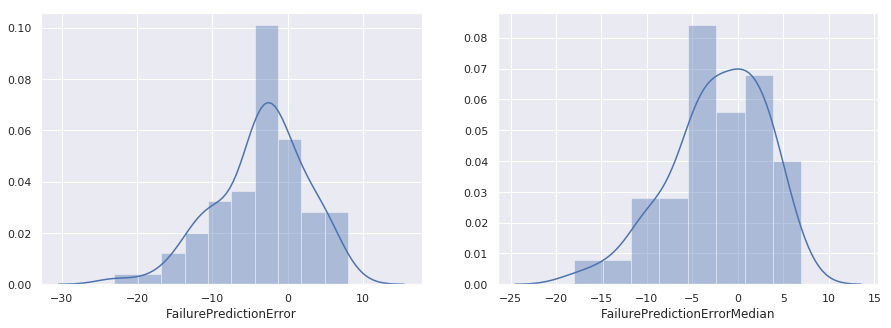

In [98]:
#a = df_predictions.plot.bar(figsize=(15,12), subplots=True)
df_predictions = map_2_n_looks_ahead(df_n_train, res['all_full']['y_train_p_cv'])

yy = list(df_predictions[df_predictions['FailureFoundAtEnd'] == 0].index)
yy_med = list(df_predictions[df_predictions['FailureFoundAtEndMedian'] == 0].index)

print('units with failure not found at end:\n{}'.format(yy))
print('units with failure not found at end (with median):\n{}'.format(yy_med))
print('\ntotal number of units where failures are not found properly:')
print('with median   : {}/{} ({}%)'.format(len(yy_med), len(df_predictions), len(yy_med) / len(df_predictions) * 100))
print('without median: {}/{} ({}%)'.format(len(yy), len(df_predictions), len(yy) / len(df_predictions) * 100))
              
fig, axes = plt.subplots(1, 2, figsize=(15,5))
axes = axes.flatten()
sns.distplot(df_predictions['FailurePredictionError'], ax=axes[0])
sns.distplot(df_predictions['FailurePredictionErrorMedian'], ax=axes[1])

Looking at the predicted values it can also be seen, that different machines show differently high predictions 

Lets try to simply average the data over a few cycles before using it for regression.

## Train the same model again, but this time with averaging the training data before

In [ ]:
filtfilt = ProcessingHelpers.apply_filtfilt_by_unit
cols_tmp = cols_features + ['unit_nr']

b = np.ones(5) / 5.0
df_n_train_avg = df_n_train.copy()
df_n_train_avg[cols_tmp] = filtfilt(df_n_train[cols_tmp], b)

PlottingHelpers.plot_grouped_by_RUL(df_n_train_avg)

In [ ]:
res_avg_full, res_avg_red = fit_and_test_clf(df_n_train_avg, df_n_test, mdl=None, cols_features=None)
    
res['avg_full'] = res_avg_full
res['avg_red'] = res_avg_red

In [ ]:
fig, axes = plt.subplots(2, 1, figsize=(15, 6), sharex=True)
axes = axes.flatten()

for name, dc2 in res.items():
    sns.distplot(dc2['dy_train_cv'], ax=axes[0])
    sns.distplot(dc2['dy_test'], ax=axes[1])
    
lbl = axes[1].set_ylabel('test units')
lbl = axes[0].set_ylabel('train cv units')

In [ ]:
df_n_train_res = df_n_train[['RUL', 'unit_nr']]
df_n_train_res['RUL_error'] = res['avg_full']['train_cv']
df_n_train_res['RUL_pred'] = res['avg_full']['train_cv'] + y_train

PlottingHelpers.plot_grouped_by_RUL(df_n_train_res, leg=False, cols_data=['RUL', 'RUL_pred', 'RUL_error'])

In [ ]:
df_n_test_res = df_n_test[['RUL', 'unit_nr']]
df_n_test_res['RUL_error'] = res['avg_red']['test_cv']
df_n_test_res['RUL_pred'] = res['avg_red']['test_cv'] + y_test

PlottingHelpers.plot_grouped_by_RUL(df_n_test_res, leg=False, cols_data=['RUL', 'RUL_pred', 'RUL_error'])

That does look like the model is converging, but the results are not very well. Lets take a look at a few more regression models.

## Test some more out of the box regression models and plot the results

In [ ]:
models = {
    "SVM": sk.svm.SVR(gamma='scale'),
    "Nearest Neighbor": KNeighborsRegressor(),
    "Decision Tree": DecisionTreeRegressor(),
    "Random Forest": RandomForestRegressor(),
    "Neural Net": MLPRegressor(),
    "Gaussian Process": GaussianProcessRegressor(1.0 * RBF(1.0)),
    'lr': sk.linear_model.LinearRegression(),
    'lasso': sk.linear_model.Lasso(alpha=.1),
    'Bridge': sk.linear_model.BayesianRidge(),
    #'Kridge': sk.kernel_ridge.KernelRidge(),
    'ridge': sk.linear_model.Ridge(),
    #'GBR': sk.ensemble.GradientBoostingRegressor(),
}

scoring = sk.metrics.mean_squared_error
res_arr = {}
for name, clf in models.items():
    mdl = sk.pipeline.Pipeline([
        ('scaler', sk.preprocessing.MinMaxScaler()),
        ('regression', models[name]),
    ])
    
    res_full, res_red = fit_and_test_clf(df_n_train, df_n_test, mdl=None, cols_features=None)
    
    res_arr[name] = {
        'res_full': res_full,
        'res_red': res_red,
    }


In [ ]:
fig, axes = plt.subplots(2, 2, figsize=(15, 6), sharex=True)

def plt_helper(df_n, y_pred, ax):
    df_n_res = df_n[['RUL', 'unit_nr', 'time']].copy()
    df_n_res['RUL_pred'] = y_pred
    sns.relplot(x="time", y="RUL_pred", hue="unit_nr", kind="line", data=df_n_res, ax = ax)
        
    
for (name, dc2), i in enumerate(res_arr.items()):
    sns.distplot(dc2['res_full']['dy_train_cv'], ax=axes[i, 0])
    sns.distplot(dc2['res_full']['dy_test'], ax=axes[i, 0])
    sns.distplot(dc2['res_red']['dy_train_cv'], ax=axes[i, 0])
    sns.distplot(dc2['res_red']['dy_test'], ax=axes[i, 0])
    
    plt_helper(df_n_train, dc2['res_full']['y_train_p_cv'], ax=axes[i, 1])
    plt_helper(df_n_train, dc2['res_full']['y_test_p'], ax=axes[i, 1])
    plt_helper(df_n_train, dc2['res_red']['y_train_p_cv'], ax=axes[i, 1])
    plt_helper(df_n_train, dc2['res_red']['y_test_p'], ax=axes[i, 1])



## Generate some more regression models as well as distributions to tune the parameters of those

In [ ]:
regressors = {
    "SVM": sk.svm.SVR(gamma='scale'),
    "Nearest Neighbor": KNeighborsRegressor(),
    "Decision Tree": DecisionTreeRegressor(),
    "Random Forest": RandomForestRegressor(),
    "Neural Net": MLPRegressor(),
    "Gaussian Process": GaussianProcessRegressor(1.0 * RBF(1.0)),
    'lr': sk.linear_model.LinearRegression(),
    'lasso': sk.linear_model.Lasso(alpha=.1),
    'Bridge': sk.linear_model.BayesianRidge(),
    #'Kridge': sk.kernel_ridge.KernelRidge(),
    'ridge': sk.linear_model.Ridge(),
    #'GBR': sk.ensemble.GradientBoostingRegressor(),
    'svr': sk.svm.SVR(gamma='scale')
}

models = {
    'lr': sk.linear_model.LinearRegression(),
    'lasso': sk.linear_model.Lasso(alpha=.1),
    'Bridge': sk.linear_model.BayesianRidge(),
    #'Kridge': sk.kernel_ridge.KernelRidge(),
    'ridge': sk.linear_model.Ridge(),
    #'GBR': sk.ensemble.GradientBoostingRegressor(),
    'svr': sk.svm.SVR(gamma='scale')
}

optimizers = {
        "SVM": {
            'C': expon(scale=100),
            'gamma': expon(scale=.1),
            'kernel': ['linear', 'rbf'],
            "shrinking": [True, False],
        },
        "Nearest Neighbor": {
            "algorithm": ["auto", "ball_tree", "kd_tree", "brute"],
            "n_neighbors": randint(1, 20),
            "weights": ["uniform", "distance"],
            "leaf_size": randint(5, 50)
        },
        "Decision Tree": {
            "min_samples_leaf": randint(1, 11),
            "criterion": ["gini", "entropy"],
            "max_depth": randint(1, 1000),
        },
        "Random Forest": {
            "min_samples_leaf": randint(1, 11),
            "bootstrap": [True, False],
            "criterion": ["gini", "entropy"],
            "max_depth": randint(1, 5),
            "warm_start": [True, False]
        },
        "Gaussian Process": None,
        "Neural Net": {
            "activation": ["identity", "logistic", "tanh", "relu"],
            "solver": ["lbfgs", "sgd", "adam"],
            "learning_rate": ["constant", "invscaling", "adaptive"],
            "hidden_layer_sizes": randint(1, 99),
            "alpha": uniform(0.000001, 2),
            "power_t": uniform(0.1, .9),
            "momentum": uniform(0.0, 1.0)
        },
        "AdaBoost": None,
        "Naive Bayes": None,
    }

In [ ]:
exclude = [ 'sensor_'.format(n) for n in ['11', '12', '13', '14'] ]
cols_features = [c for c in df_n_train.columns if c.startswith('s') and c not in exclude]

print(cols_features)

In [ ]:
X_train = df_n_train[cols_features].values
n_jobs = 1
validator = StratifiedKFold(5, random_state=0)

scoring = sk.metrics.mean_squared_error
res = {}
lock = True
if lock:
    print('not performing optimization, because it takes so long. make sure to set lock to '
          + 'False if you are really sure you want to run it')
else:
    for name, mdl in regressors.items():

        # use the parameters given in RandomizedSearchCV
        rscv = RandomizedSearchCV(mdl, optimizers[name],
                                       n_iter=125, n_jobs=n_jobs,
                                       cv=validator, scoring='neg_mean_squared_error',
                                       refit=True, random_state=0
                                       )

        # find the best fitting classifier
        rscv.fit(X_train, y_train)
        clf = self.rscv.best_estimator_


        y_cv = sk.model_selection.cross_val_predict(
            mdl,
            X_train,
            y_train,
            cv=3)

        res[name] = {
            'mdl': mdl,
            'y_cv': y_cv
        }

    fig, axes = plt.subplots(len(models), 1, figsize=(15,12))
    axes = axes.flatten()
    for ax, name in zip(axes, res.keys()):
        s = "{}: cv test mse: {}".format(name, -scoring(y_cv, y_train))
        y_cv = res[name]['y_cv']
        sns.distplot(y_cv - y_train, ax=ax)
        #ax.set_title(s)
